Importing a few useful libraries

In [1]:
import bs4
from bs4 import BeautifulSoup
import requests
import os.path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict
from collections import Counter
from IPython.core.display import HTML
import time
import nltk

# custom libraries
from data_collection import *
from tsv_management import *
from search_engine import *
from custom_search_engine import *

# nltk text preprocessing utilities
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

# to be executed once
#nltk.download('wordnet')
#nltk.download('stopwords')  
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('universal_tagset')

# 1. Data Collection

We start by retrieving the list of links associated to every anime.

In [1]:
link_retrieval()

We retrieved a total of 19128 anime links.

We then we crawl every page in an html file.

In [2]:
total_anime = data_crawling()

Because of the large number of requests, the site would stop the access every once in a while; to deal with this problem we set a waiting time between each request (0.1 s) and a 60 seconds pause every time the site returns a captcha page. This allowed us to download all the pages in about 12 hours.

Now we parse from every html file the data we are interested in into a dictionary. In doing so we also checked if some values contain a tab character, and we removed them. Finally we saved every dictionary into a tsv file.

In [3]:
tsv_gen()

We wrote a set of useful functions to retrieve the informations about every anime from these tsv files. The details can be found in the library `tsv_management.py`. Here we give some simple examples on how to use them:

In [8]:
titles = column_retrieval('animeTitle')  # returns the value of the input column for every anime

## NOTE: the tsv files are indexed starting from 1
anime_8 = tsv_retrieval(8)  # reads the data in anime_8.tsv and returns it in a dictionary

all_anime = load_all_tsv()   # returns the dictionaries associated to every anime in one list

In [10]:
print(titles[7])
print(anime_8['animeTitle'])
print(all_anime[7]['animeTitle'])

Ginga Eiyuu Densetsu
Ginga Eiyuu Densetsu
Ginga Eiyuu Densetsu


In [125]:
animeType = column_retrieval('animeType')
Counter(animeType)

Counter({'TV': 5515,
         'OVA': 3933,
         'Movie': 3476,
         'ONA': 2211,
         'Special': 2294,
         'Music': 1648,
         None: 51})

# 2. Search Engine

We start by defining some utilities to preprocess out data:

We will perform the following operations for text preprocessing:
1. Regex tokenization (to tokenize and remove punctuation all at once)
2. Convert every token to lowercase
3. Stopwords removal (according to NLTK stopwords library for the english language)
4. Stemming using Porter stemmer (to both normalize and stem the words)

We wrote a function for this exact purpose:

In [3]:
preprocessing('Sample text\n These words will be tokenized and stemmed\n')

['sampl', 'text', 'word', 'token', 'stem']

We start by generating our vocabulary of all the words in the anime descriptions which associates every word to an integer:

In [2]:
vocabulary_generation()

Preprocessing documents: 100%|██████████| 19128/19128 [03:42<00:00, 85.89it/s] 


The vocabulary is saved in a json file. We will read it from the disk as needed:

In [3]:
vocabulary = vocabulary_retrieval()

We can also easly invert the dictionary to find the word corresponding to a certain integer:

In [6]:
integer_to_word = vocabulary_inversion(vocabulary)
print(vocabulary[integer_to_word[7]], integer_to_word[7])

7 reishin


## 2.1. Conjunctive query

Our first search engine will just sarch for all the anime that contain the query in the description.

We start by building our first inverted index using the anime descriptions. Because each word is associated to an integer, and because our inverted index will contain all the words in our vocabulary (from 0 to `len(vocabulary)`), we decided to store the inverted index as a list of lists, in which the $i^{th}$ entry corresponds to the inverted list associated to the word indexed by $i$.

In [2]:
unranked_inverted_index_generation()

Building the inverted index: 100%|██████████| 19128/19128 [00:02<00:00, 9160.42it/s] 


Just as the vocabulary, our inverted index is saved in a json file, and we will read it as part of the search engine initialization. Before starting with the actual search, we want to comment some choices that we made during the implementation of the engine:

* We index the anime starting from $1$ (just as the tsv file names), so we decided to assign the index $0$ to a (virtual) document that contain every word in the vocabulary. Because of this choice every sublist of our inverted index list starts with this $0$ index. This choice has been dictated by a convenience in the computation of the intersection: having a universal document makes it so that the intersection between elements of the inverted index will never be empty, and allows us to terminate the algorithm with minimal effort in terms of length checking.

* The other choice we made regards the algorithm that computes the intersection between the elements of the inverted index. As said before, thanks to our choice of defining the universal $0$ document, the intersections will never be empty; this brings some convenience in terms of checking whether the algorithm has finished or not. Our other "unusual" choice regards the fact that we start intersecting the lists starting from their last element and proceeding backwards, so that the universal document will always be our last match.

We are now ready to initialize our search engine. What this does is loading the inverted index and the vocabulary in memory to have them ready for the search.

In [7]:
## YOU NEED TO EXECUTE THIS ONLY ONCE
vocabulary, unranked_inverted_index = unranked_search_engine_initialization()

And we are now ready to search for some anime!

In [8]:
unranked_search(vocabulary, unranked_inverted_index)

Input a query: saiyan race



4 search results found!



animeTitle,animeDescription,Url
Dragon Ball Z Special 1: Tatta Hitori no Saishuu Kessen,"Bardock, Son Goku's father, is a low-ranking Saiyan soldier who was given the power to see into the future by the last remaining alien on a planet he just destroyed. He witnesses the destruction of his race and must now do his best to stop Frieza's impending massacre. (Source: ANN)",https://myanimelist.net/anime/986/Dragon_Ball_Z_Special_1__Tatta_Hitori_no_Saishuu_Kessen
Dragon Ball Kai,"Five years after the events of Dragon Ball, martial arts expert Gokuu is now a grown man married to his wife Chi-Chi, with a four-year old son named Gohan. While attending a reunion on Turtle Island with his old friends Master Roshi, Krillin, Bulma and others, the festivities are interrupted when a humanoid alien named Raditz not only reveals the truth behind Gokuu's past, but kidnaps Gohan as well. With Raditz displaying power beyond anything Gokuu has seen before, he is forced to team up with his old nemesis, Piccolo, in order to rescue his son. But when Gokuu and Piccolo reveal the secret of the seven mystical wish-granting Dragon Balls to Raditz, he informs the duo that there is more of his race, the Saiyans, and they won’t pass up an opportunity to seize the power of the Dragon Balls for themselves. These events begin the saga of Dragon Ball Kai, a story that finds Gokuu and his friends and family constantly defending the galaxy from increasingly more powerful threats. Bizarre, comical, heartwarming and threatening characters come together in a series of battles that push the powers and abilities of Gokuu and his friends beyond anything they have ever experienced.",https://myanimelist.net/anime/6033/Dragon_Ball_Kai
Dragon Ball Super: Broly,"Forty-one years ago on Planet Vegeta, home of the infamous Saiyan warrior race, King Vegeta noticed a baby named Broly whose latent power exceeded that of his own son. Believing that Broly's power would one day surpass that of his child, Vegeta, the king sends Broly to the desolate planet Vampa. Broly's father Paragus follows after him, intent on rescuing his son. However, his ship gets damaged, causing the two to spend years trapped on the barren world, unaware of the salvation that would one day come from an unlikely ally. Years later on Earth, Gokuu Son and Prince Vegeta—believed to be the last survivors of the Saiyan race—are busy training on a remote island. But their sparring is interrupted when the appearance of their old enemy Frieza drives them to search for the last of the wish-granting Dragon Balls on a frozen continent. Once there, Frieza shows off his new allies: Paragus and the now extremely powerful Broly. A legendary battle that shakes the foundation of the world ensues as Gokuu and Vegeta face off against Broly, a warrior without equal whose rage is just waiting to be unleashed. [Written by MAL Rewrite]",https://myanimelist.net/anime/36946/Dragon_Ball_Super__Broly
Dragon Ball Z,"Five years after winning the World Martial Arts tournament, Gokuu is now living a peaceful life with his wife and son. This changes, however, with the arrival of a mysterious enemy named Raditz who presents himself as Gokuu's long-lost brother. He reveals that Gokuu is a warrior from the once powerful but now virtually extinct Saiyan race, whose homeworld was completely annihilated. When he was sent to Earth as a baby, Gokuu's sole purpose was to conquer and destroy the planet; but after suffering amnesia from a head injury, his violent and savage nature changed, and instead was raised as a kind and well-mannered boy, now fighting to protect others. With his failed attempt at forcibly recruiting Gokuu as an ally, Raditz warns Gokuu's friends of a new threat that's rapidly approaching Earth—one that could plunge Earth into an intergalactic conflict and cause the heavens themselves to shake. A war will be fought over the seven mystical dragon balls, and only the strongest will survive in Dragon Ball Z. [Written by MAL Rewrite

## 2.2. Conjunctive query & Ranking score

We now want to improve the engine by adding a ranking for the search results based on some similarity with the query. For this purpose we will consider every document as a vector in which the elements are the tfIdf scores of every word in the document.

We start by building the new inverted index, which will now consist of a dicionary fo the form:
```
{
term_id_1:[(document1, tfIdf_{term,document1}), (document2, tfIdf_{term,document2}), (document4, tfIdf_{term,document4}), ...],
term_id_2:[(document1, tfIdf_{term,document1}), (document3, tfIdf_{term,document3}), (document5, tfIdf_{term,document5}), (document6, tfIdf_{term,document6}), ...],
...}

```

In [62]:
ranked_inverted_index_generation()

Ranked inverted index generation: 100%|██████████| 19128/19128 [00:02<00:00, 6879.75it/s] 


Just as the vocabulary, our inverted index is saved in a json file, and we will read it as part of the search engine initialization. The intersection algorithm will be a specular version of the previous one, we just adapted it to the new data types. The similarity between the document and the query will be given by

\begin{equation}
\frac{\mathbf q \cdot \mathbf v }{\| \mathbf v \|}
\end{equation}

where $\mathbf q$ and $ \mathbf v$ are the tfidf vectors of the query and the document (respectively). For this purpose, in the previous function we also generated a dictionary of all the tfidf vectors and we saved it on the disk.

We are now ready to initialize our search engine. What this does is loading the inverted index, the vocabulary and the tfidf vector of every document in memory to have them ready for the search.

In [7]:
## YOU NEED TO EXECUTE THIS ONLY ONCE
vocabulary, ranked_inverted_index, tfidf_vectors, total_documents = ranked_search_engine_initialization()

And we are now ready to search for some anime!

In [8]:
ranked_search(vocabulary, ranked_inverted_index, tfidf_vectors, total_documents, k = 5)

Input a query: saiyan race


animeTitle,animeDescription,Url,Similarity
Dragon Ball Z Special 1: Tatta Hitori no Saishuu Kessen,"Bardock, Son Goku's father, is a low-ranking Saiyan soldier who was given the power to see into the future by the last remaining alien on a planet he just destroyed. He witnesses the destruction of his race and must now do his best to stop Frieza's impending massacre. (Source: ANN)",https://myanimelist.net/anime/986/Dragon_Ball_Z_Special_1__Tatta_Hitori_no_Saishuu_Kessen,0.554850
Dragon Ball Super: Broly,"Forty-one years ago on Planet Vegeta, home of the infamous Saiyan warrior race, King Vegeta noticed a baby named Broly whose latent power exceeded that of his own son. Believing that Broly's power would one day surpass that of his child, Vegeta, the king sends Broly to the desolate planet Vampa. Broly's father Paragus follows after him, intent on rescuing his son. However, his ship gets damaged, causing the two to spend years trapped on the barren world, unaware of the salvation that would one day come from an unlikely ally. Years later on Earth, Gokuu Son and Prince Vegeta—believed to be the last survivors of the Saiyan race—are busy training on a remote island. But their sparring is interrupted when the appearance of their old enemy Frieza drives them to search for the last of the wish-granting Dragon Balls on a frozen continent. Once there, Frieza shows off his new allies: Paragus and the now extremely powerful Broly. A legendary battle that shakes the foundation of the world ensues as Gokuu and Vegeta face off against Broly, a warrior without equal whose rage is just waiting to be unleashed. [Written by MAL Rewrite]",https://myanimelist.net/anime/36946/Dragon_Ball_Super__Broly,0.341980
Dragon Ball Z,"Five years after winning the World Martial Arts tournament, Gokuu is now living a peaceful life with his wife and son. This changes, however, with the arrival of a mysterious enemy named Raditz who presents himself as Gokuu's long-lost brother. He reveals that Gokuu is a warrior from the once powerful but now virtually extinct Saiyan race, whose homeworld was completely annihilated. When he was sent to Earth as a baby, Gokuu's sole purpose was to conquer and destroy the planet; but after suffering amnesia from a head injury, his violent and savage nature changed, and instead was raised as a kind and well-mannered boy, now fighting to protect others. With his failed attempt at forcibly recruiting Gokuu as an ally, Raditz warns Gokuu's friends of a new threat that's rapidly approaching Earth—one that could plunge Earth into an intergalactic conflict and cause the heavens themselves to shake. A war will be fought over the seven mystical dragon balls, and only the strongest will survive in Dragon Ball Z. [Written by MAL Rewrite]",https://myanimelist.net/anime/813/Dragon_Ball_Z,0.233947
Dragon Ball Kai,"Five years after the events of Dragon Ball, martial arts expert Gokuu is now a grown man married to his wife Chi-Chi, with a four-year old son named Gohan. While attending a reunion on Turtle Island with his old friends Master Roshi, Krillin, Bulma and others, the festivities are interrupted when a humanoid alien named Raditz not only reveals the truth behind Gokuu's past, but kidnaps Gohan as well. With Raditz displaying power beyond anything Gokuu has seen before, he is forced to team up with his old nemesis, Piccolo, in order to rescue his son. But when Gokuu and Piccolo reveal the secret of the seven mystical wish-granting Dragon Balls to Raditz, he informs the duo that there is more of his race, the Saiyans, and they won’t pass up an opportunity to seize the power of the Dragon Balls for themselves. These events begin the saga of Dragon Ball Kai, a story that finds Gokuu and his friends and family constantly defending the galaxy from increasingly more powerful threats. Bizarre, comical, heartwarming and threatening characters come together in a series of battles that push the powers and abilities of Gokuu and his friends beyond 

As we can see, the results are now ranked by this measure of similarity between documents. The rank though, does not seem very satisfying to us, since the first place contains a special of the main anime, which is ranked third. This fact will be of guidance for the next exercise.

# 3. Define a new score!

At this point, since we have so many informations on each anime, we would like to be able to use more of them to achieve better search results. Before explaining our choices we wanto to make a remark: looking at the data we noticed that the informations were not all mutually independent, specifically we noticed that the anime are ranked in decreasing order of Score; we made the same hypotesis about the popularity and the number of members, but it seems only weakly verified (the ordering is not strictly preserved but is of by a small number of members, we think it is because of some delay between the update of the number of members and the update of the popularity in the site).

Having made these two remarks, we decided to only use the informations on the score, the popularity and the type of every anime. The informations about the aired dates seemed hard to use effectively without implementing an explicit filter, and the number of users did not seem useful to our purpose. We thought about using the anime related informations in a page rank fashion but we ended up discarding the idea to not add too much "randomness" to our formulas.

We also decided to treat the title, the characters names, the voices names and the staff names just like the description, so we ended up using 8 of the 15 (not independent) information we retrieved about every anime. Here is a summary of what we did:
1. We built a new vocabuary and inverted index based on the description, characters names, voices names and staff names
2. We assigned a custom popularity score to each anime
3. Given a query, we search for all the documents that have at least one word in common with the query
4. We rank these last results using a custom index that is based on the similarity and on the previously mentioned popularity score

We start with the first point: because most titles are not in english, we thought that the stemmer could return unexpected results and we changed the way we preprocess the documents. What we do is:
1. Regex tokenization (to tokenize and remove punctuation all at once)
2. Convert every token to lowercase
3. Stopwords removal (according to NLTK stopwords library for the english language)
4. Tag each word using the NLTK tagger
5. Lemmatize the couple (word, tag) using WordNet Lemmatizer

Because the lemmatizer is based on an actual database of words, we thought that the japanese titles would have a higher chance of survival than with the stemming. Here is an example:

In [11]:
lemmatization_preprocessing('Sample text\n These words will be tokenized and lemmatized\n The title Ginga Eiyuu Densetsu is left untouched!')

['sample',
 'text',
 'word',
 'tokenized',
 'lemmatized',
 'title',
 'ginga',
 'eiyuu',
 'densetsu',
 'leave',
 'untouched']

We start, as usual, by building a new vocabulary of words based on all the textual informations that we have. We will save it to the disk and retrieve it as needed.

In [140]:
titles_descriptions_vocabulary_generation()

Preprocessing documents: 100%|██████████| 19128/19128 [00:19<00:00, 959.20it/s] 


We wanted the user to be able to choose if he's searching for a specific anime or if he wants to do a broader search, so we had to keep the description separated from the other textual informations. Because of this, we created a tfidf vector for the descriptions, and a tfidf vector for the other informations (title, characters, voices and staff names; we will sometimes call this vector "partial" or just "titles"). Since we keep the tfidfs separated, we built an unranked inverted index (in the exact same way as the first search engine) and we stored it as a list of lists (we still adopt the universal 0 document convention that we established before). We saved these three objects in three distinct json files, to retrieve them when needed.

In [339]:
titles_descriptions_inverted_index_generation()

TfIdf vectors generation: 100%|██████████| 19128/19128 [00:02<00:00, 6712.85it/s] 


We the proceeded to retrieve the other information that we wanted to use about the anime from the disk, specifically we retrieve for each anime:
* The Score
* The rank of Popularity
* The Type

Since Score (float in $[2,10]$) and rank of Popularity (integer in $[1,19128]$) are on totally different scales, we decided to normalize them in the interval $(0,1)$ in the following way:
* $newScore\ =\ f(Score,\ 10)$
* $newPopularity\ =\ f(19129-Popularity,\ 19128)$
where $f(x,m)$ is a function that squeezes (with respect to $x$) the interval $(0,m)$ in the interval $(0,1)$ in a nonlinear way near the borders (it gives the same weight to higher scores). We plot $f(x,1)$ below, see the implementation in the library `custom_search_engine.py`, in the function `anime_scoring_info_creation()` for the actual functional form of $f$.

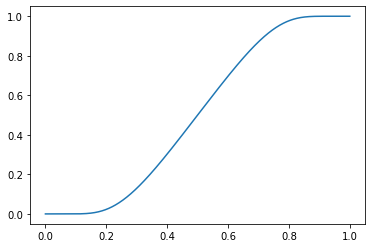

In [22]:
np.seterr(all="ignore")
x = np.linspace(0,1,1000)
plt.plot(x, bump_function(x, max = 1))
plt.show()

Once we obtain these new two scores, we save them to the disk along with the anime type:

In [168]:
anime_scoring_info_creation()

Retrieving tsv: 100%|██████████| 19128/19128 [00:03<00:00, 4787.86it/s]


Before starting the search, we give some more details about the actual implementation and the rankings. Once we retrieve all the documents that have at least one word in common with the query (see `union_pointers()` in `custom_search_engine.py` for the actual implementation of the union algorithm), we proceed to calculate the tfidf vector associated with the document in the following way:

$$tfidf_{document}(word) = \alpha * tfidf_{title}(word)+(1-\alpha) * tfidf_{description}(word)$$

where $tfidf_{title}(word)$ is the tfidf of a word seen as part of the title (and characters, etc..) document and $tfidf_{description}(word)$ is the tfidf of a word seen as part of the description document (where a tfidf is 0 if the word isn't in the document), and $\alpha$ is a parameter chosen by the user.

We then compute the cosine similarity (here we take into account the norm of the query too, because we want a result smaller than 1) between the query and this new tfidf vector. Having run some trials, we noticed that the similarity gave a lot of priority to documents with brief descriptions (as for these documents the tf comes out higher than for longer documents); the tfidf is better suited to work with large documents (for which the term frequency is more meaningful). To overcome this last problem we renormalize the final similarity with a number that depends on the length of the document; the functional form is an arch of ellipse, we choose the parameters with some trials and errors. You can look at the details in `description_titles_cosine_similarity()` inside `custom_search_engine.py`, here we limit ourselves to a simple plot:

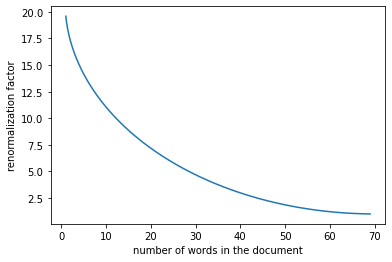

In [26]:
def ellipse (x):
    f = -20 * np.sqrt(1-0.000209*(x-70)**2)+21
    return(f)

x = np.linspace(1,69,1000)
plt.plot(x, ellipse(x))
plt.xlabel('number of words in the document')
plt.ylabel('renormalization factor')
plt.show()

After computing this new similarity score, we do two last modification to obtain the final score. Firstly we define for each anime the popularity ranking score as the average of the popularity and the rank score defined above; then we compute:

$$score = similarity * ( 1.5 - \alpha ) + PopularityRankingScore * \alpha$$
where $\alpha$ is another parameter chosen by the user. Finally, we let the user enter a preference for the anime type, and we increase the final score by a fixed percentage if the anime matches the desired type (see the global variable `type_modifier` inside `custom_search_engine.py` for the exact number).

We are now ready to initialize the search engine:

In [9]:
custom_vocabulary, inverted_index, description_tf_idf, partial_tf_idf, anime_scoring_info, parameters_list, total_documents = custom_search_engine_initialization()

And here we can customize the engine parameters:

In [5]:
parameters_list = search_engine_customization()

Hi! Here you can tune some search engine parameters to fit your search needings.



Do you want to have a detailed explanation of the role of every parameter? (Y/n) y


To compute the final tfidf vector associated to the document we computed two separate tfidf vectors: one for the description and one for the titles, characters, voices and staff; and we combined the tfidf for each word according to the following formula:
 final_tfidf = alpha * title_tfidf + (1 - alpha) * description_tfidf
 where title_tfidf is the tfidf of the word in the titles, characters, voices and staff texts, and description_tfidf is the tfidf of the word in the description text. The parameter we ask you to choose is the alpha in the above formula, and it represents the weight of the titles texts in the final computation for the cosine similarity.
 alpha = 1 will give max priority to words in the query that match a word in titles, characters, voices and staff texts
 alpha = 0 will give max priority to words in the query that match a word in the description
 Thus by varying this parameter you will be able to decide if you search for a specific anime (alpha near 1), or if you want 

Are you searching for a specific anime or you want something generic that fits your query?
 Input a number in [0,1] where 0 is generic and 1 is specific:  0.9


After computing the cosine similarity based on the parameter above, we convolute the similarity with a specific score that is based on the popularity of the anime according to the following:
 final_score = similarity * ( 1.5 - alpha ) + popularity_ranking_score * alpha
 where the popularity_ranking_score is computed starting from the animePopularity and animeScore in the data in the following way:
 rank_score = f(animeScore, 10)
 popularity_score = f(19129 - animePopularity, 19128)
 where f(x,m) is a certain smooth function that squeezes all the numbers in (0,m) in the interval (0,1) in a nonlinear way near the borders.
 See the implementation in the library custom_search_engine.py, in anime_scoring_info_creation() for more details about the function.
 After obtaining the rank_score and the popularity_score, we compute the final rank as a simple average:
 popularity_ranking_score = (popularity_score + rank_score)/2
 The parameter we ask you to choose is the alpha in the above formula, 

Would you like to rank the anime based on their popularity or based on their score?
 Input a number in [0,1] where 0 is rank by popularity and 1 is rank by score:  0.9


Here we ask you to specify if you prefer a specific type of anime among the following:
 Movie, Music, ONA, OVA, Special, TV
 This is an important choice since most of the anime that are not TV are special or side stories of a TV one.
 This will allow you to filter out some of the secondary story anime or to search specifically for them.
 The ranking boost works in this way: given a final similarity score, if the anime type coincides with the desired one
 the score will be increased by a fixed percentage (see the global variable type_modifier in the library custom_search_engine.py).
 NOTE: if you choose All or if you type an incorrect anime type, we will not take into account at all the type of the anime in the final score.


Are you searching for a specific anime Type? Choose among the following:
Movie, Music, ONA, OVA, Special, TV, All
 tv


The parameter you just chose are passed to the search engine as a list:
 [isSpecific, Type, popularity_relevance]
 With this knowledge you can edit these parameters directly if you wish, and you can also bypass the restriction of the numerical parameters being in (0.1, 0.9).
 This last thing can bring unexpected results, experiment freely with this in mind.



In [10]:
custom_search(custom_vocabulary, inverted_index, description_tf_idf, partial_tf_idf, total_documents, anime_scoring_info, parameters_list, k = 5)

Input a query: saiyan race


animeTitle,animeDescription,animeType,animeScore,animePopularity,Url,Custom score
Dragon Ball Z Movie 14: Kami to Kami,"Following the defeat of a great adversary, Gokuu Son and his friends live peaceful lives on Earth. Meanwhile, in space, Beerus the God of Destruction awakens from his long slumber, having dreamed of an entity known as a Super Saiyan God. With the help of his assistant, Whis, Beerus looks for this powerful being, as he wishes to fight a worthy opponent. After discovering that the Saiyan home planet was destroyed, he tracks down the remaining Saiyans on Earth, looking for Gokuu specifically. Having only heard of the Super Saiyan God in legends, Gokuu and his comrades summon Shen Long the Eternal Dragon, who they find out is afraid of Beerus. After learning the secret of the Super Saiyan God, an intense battle between Gokuu and Beerus commences, the immense power of which puts the Earth in terrible danger. [Written by MAL Rewrite]",Movie,7.39,987,https://myanimelist.net/anime/14837/Dragon_Ball_Z_Movie_14__Kami_to_Kami,0.737447
Dragon Ball Z Special 1: Tatta Hitori no Saishuu Kessen,"Bardock, Son Goku's father, is a low-ranking Saiyan soldier who was given the power to see into the future by the last remaining alien on a planet he just destroyed. He witnesses the destruction of his race and must now do his best to stop Frieza's impending massacre. (Source: ANN)",Special,7.55,1785,https://myanimelist.net/anime/986/Dragon_Ball_Z_Special_1__Tatta_Hitori_no_Saishuu_Kessen,0.709900
"Dragon Ball Z Movie 08: Moetsukiro!! Nessen, Ressen, Chougekisen","As Goku investigates the destruction of the Southern Galaxy, Vegeta is taken to be King of the New Planet Vegeta, and to destroy the Legendary Super Saiyan, Broly. (Source: ANN)",Movie,7.32,1271,https://myanimelist.net/anime/901/Dragon_Ball_Z_Movie_08__Moetsukiro_Nessen_Ressen_Chougekisen,0.685352
Initial D Battle Stage,There are many street races in the Initial D Series. This OVA has no plot other than to collect all the street races into one stage. The dialog during the original races is left in.,OVA,7.56,3228,https://myanimelist.net/anime/821/Initial_D_Battle_Stage,0.672249
Dragon Ball Z Movie 10: Kiken na Futari! Super Senshi wa Nemurenai,"After his loss to Goku, Broly crash lands and hibernates on earth. After some time, he is awakened by Trunks and Goten, who Broly believes is Kakarott, and goes on a rampage to kill both of them. At the same time, Gohan is on his way to challenge the Legendary Super Saiyan alone.",Movie,6.79,1466,https://myanimelist.net/anime/903/Dragon_Ball_Z_Movie_10__Kiken_na_Futari_Super_Senshi_wa_Nemurenai,0.611405


## Search engine comparisons

Here we perform some comparisons between the our custom search engine and the ranked search engine we built before.

As a first example, by searching the top 3 for the query `naruto` we see that the ranked search gives only 2 anime about naruto, the first one and the third one, but neither is the TV series (which is the most popular). On the other hand the custom search, tuned by popularity, gives back the two main series in the first 3 places.

In [12]:
ranked_search(vocabulary, ranked_inverted_index, tfidf_vectors, total_documents, k = 3)

Input a query: naruto


animeTitle,animeDescription,Url,Similarity
"Naruto: Shippuuden - Shippuu! ""Konoha Gakuen"" Den",Naruto school special. Naruto is a new cool student and when he meets Sasuke they start fighting.,https://myanimelist.net/anime/4134/Naruto__Shippuuden_-_Shippuu_Konoha_Gakuen_Den,1.987909
Juliet,"Based on the manga by U-Jin. This is a story of two siblings, Anzu and Naruto Nozaki, heirs to the fabulous Nozaki fortune. Naruto appears to be an overbearing sis-con. In fact, he's madly in love with Anzu, because they're not blood-related. He confines her to the family mansion for ""security,"" depriving her of companionship and a real life. At age 16, she starts to rebel. She smuggles in a kitten as a pet (Naruto hates cats) and then escapes in a delivery truck. Naruto catches up to her and realizes that she can't be confined like a bird in a cage. He agrees to let have a normal life, but just then, tragedy strikes (Source: Collectr)",https://myanimelist.net/anime/8993/Juliet,1.241344
Naruto: Shippuuden Movie 6 - Road to Ninja,"Returning home to Konohagakure, the young ninja celebrate defeating a group of supposed Akatsuki members. Naruto Uzumaki and Sakura Haruno, however, feel differently. Naruto is jealous of his comrades' congratulatory families, wishing for the presence of his own parents. Sakura, on the other hand, is angry at her embarrassing parents, and wishes for no parents at all. The two clash over their opposing ideals, but are faced with a more pressing matter when the masked Madara Uchiha suddenly appears and transports them to an alternate world. In this world, Sakura's parents are considered heroes—for they gave their lives to protect Konohagakure from the Nine-Tailed Fox attack 10 years ago. Consequently, Naruto's parents, Minato Namikaze and Kushina Uzumaki, are alive and well. Unable to return home or find the masked Madara, Naruto and Sakura stay in this new world and enjoy the changes they have always longed for. All seems well for the two ninja, until an unexpected threat emerges that pushes Naruto and Sakura to not only fight for the Konohagakure of the alternate world, but also to find a way back to their own. [Written by MAL Rewrite]",https://myanimelist.net/anime/13667/Naruto__Shippuuden_Movie_6_-_Road_to_Ninja,1.159498


In [13]:
parameters_list = [0.1, 'all', 0.9]
custom_search(custom_vocabulary, inverted_index, description_tf_idf, partial_tf_idf, total_documents, anime_scoring_info, parameters_list, k = 3)

Input a query: naruto


animeTitle,animeDescription,animeType,animeScore,animePopularity,Url,Custom score
Naruto: Shippuuden,"It has been two and a half years since Naruto Uzumaki left Konohagakure, the Hidden Leaf Village, for intense training following events which fueled his desire to be stronger. Now Akatsuki, the mysterious organization of elite rogue ninja, is closing in on their grand plan which may threaten the safety of the entire shinobi world. Although Naruto is older and sinister events loom on the horizon, he has changed little in personality—still rambunctious and childish—though he is now far more confident and possesses an even greater determination to protect his friends and home. Come whatever may, Naruto will carry on with the fight for what is important to him, even at the expense of his own body, in the continuation of the saga about the boy who wishes to become Hokage. [Written by MAL Rewrite]",TV,8.22,16,https://myanimelist.net/anime/1735/Naruto__Shippuuden,1.157615
Naruto: Shippuuden Movie 6 - Road to Ninja,"Returning home to Konohagakure, the young ninja celebrate defeating a group of supposed Akatsuki members. Naruto Uzumaki and Sakura Haruno, however, feel differently. Naruto is jealous of his comrades' congratulatory families, wishing for the presence of his own parents. Sakura, on the other hand, is angry at her embarrassing parents, and wishes for no parents at all. The two clash over their opposing ideals, but are faced with a more pressing matter when the masked Madara Uchiha suddenly appears and transports them to an alternate world. In this world, Sakura's parents are considered heroes—for they gave their lives to protect Konohagakure from the Nine-Tailed Fox attack 10 years ago. Consequently, Naruto's parents, Minato Namikaze and Kushina Uzumaki, are alive and well. Unable to return home or find the masked Madara, Naruto and Sakura stay in this new world and enjoy the changes they have always longed for. All seems well for the two ninja, until an unexpected threat emerges that pushes Naruto and Sakura to not only fight for the Konohagakure of the alternate world, but also to find a way back to their own. [Written by MAL Rewrite]",Movie,7.67,640,https://myanimelist.net/anime/13667/Naruto__Shippuuden_Movie_6_-_Road_to_Ninja,1.154822
Naruto,"Moments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto. Now, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning desire to become the Hokage of Konohagakure leads him not only to some great new friends, but also some deadly foes. [Written by MAL Rewrite]",TV,7.95,8,https://myanimelist.net/anime/20/Naruto,1.153523


From now on will omit the actual search to not fill the notebook with wall of text.

We obtain similar result also by choosing as set of parameters: `[0.9, 'all', 0.1]`. In this last case the first ranked anime is Juliet, in which one of the characters is called Naruto as well, but the other two positions are occupied by the two main series.

Setting `[0.1, 'all', 0.9]`, if we search for 'one piece', we retrieve the main serie along with two movies with our search engine, while the ranked search only found the two associated movies.

One of the main advantages in using our search engine is the fact that we account for the title and the anime characters name, while the ranked search does not. This can bring to very different result, since one could wish to search by title.

# 4. BONUS: Understanding the anime's reviews
We start by crawling the reviews pages from the web:

In [ ]:
total_reviews = reviews_crawl()

And then we parse them and we save them in various txt files:

In [2]:
txt_gen()

100%|██████████| 19128/19128 [42:09<00:00,  7.56it/s] 


and then we merge every review in one file for better file management (as it is hard to move around multiple smaller files)

In [2]:
merge_txt()

Retrieving txt: 100%|██████████| 19128/19128 [00:06<00:00, 3019.37it/s]


To perform the sentiment analysis we followed the guide found in https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

We used the get_data function to get IMDB Reviews Dataset that contains 25,000 movie reviews for training and 25,000 for testing. All these 50,000 reviews are labeled. we downloaded the dataset from Stanford’s relevant directory `tf.keras.utils.get_file`. After getting the data we created 2 pandas dataset (train and test) from text_dataset_from_directory of tensorflow library. We had to convert the 2 pandas dataframe into objects that are suitable objects for the BERT model. We achieve this convertions using 2 functions `convert_data_to_examples()` and `convert_examples_to_tf_dataset()`. The first one converts every row of pandas dataframe into an InputExample object. The other one creates the required input format with the tokenized InputExample objects and then create an input dataset that we can feed to the model. We used a stochastic gradient descent method from tensorflow (https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), using CategoricalCrossentropy as our loss function, and SparseCategoricalAccuracy. After this we retrieved the reviews, we tokenized them, and than we gave to the pretrained model and we run a final softmax layer to get the predictions, using the argmax to get if a review is positive or negative. We wrote the result as a dict {anime_id:(number of positive,number of negative)} and we saved it in the `review_sentiment_dict.txt`.

## 5. Algorithmic question
You consult for a personal trainer who has a *back-to-back sequence* of requests for appointments. A sequence of requests is of the form
    > 30, 40, 25, 50, 30, 20
where each number is the time that the person who makes the appointment wants to spend.
You need to accept some requests, however you need a break between them, so you cannot accept two consecutive requests. For example, `[30, 50, 20]` is an acceptable solution (of duration *100*), but `[30, 40, 50, 20]` is not, because *30* and *40* are two consecutive appointments. Your goal is to provide to the personal trainer a schedule that maximizes the total length of the accepted appointments. For example, in the previous instance, the optimal solution is `[40, 50, 20]`, of total duration *110*.
1. Write an algorithm that computes the acceptable solution with the longest possible duration.
2. Implement a program that given in input an instance in the form given above, gives the optimal solution.

We start by making some remarks about the optimal solution. Let's suppose that, in a given day, the personal trainer receives $n$ requests $[r_1,r_2,\dots,r_n]$, and let's define $S = [s_1, \dots, s_k]$ as the (ordered) subset of appointments that will form our optimal solution for our problem in the given day.
* An important observation is that, by definition, if $r_i$ is in the optimal solution, then neither $r_{i-1}$ nor $r_{i+1}$ belong to this solution. This is expression of the fact that we do not want to accept two consecutive appointments.
* Another crucial observation that we want to make is that, given any couple of consecutive elements $r_i, r_j$ that are in the optimal solution, their distance is no more than $3$, i. e. $j-i\leq 3$. I other words, given any three consecutive appointments of durations $r_i, r_{i+1}, r_{i+2}$, at least one of them is in the optimal solution. This fact is, in some sense, pretty intuitive, and it comes from the fact that our optimal solution is the longest possible, i.e. the one for which the quantity $\sum s_j$ is maximized. The proof of this fact is trivial and we will just illustrate it with an example. Suppose that the followings are five consecutive appointments requested today: $[r_1,r_2,r_3,r_4,r_5]$ and assume that, among them, just $r_1,r_5$ are in the optimal solution; then, by adding $r_3$ to the solution we find another valid solution, which is longer than the optimal one, which is absurd.
* Finally, from the two observation above, given any three consecutive elements $r_i, r_{i+1}, r_{i+2}$, either one or two of them belong to the optimal solution (three of them is not acceptable by the first remark, none of them is not acceptable by the second remark).

One last note before starting: this problem may have more than one optimal solution, our algorithm returns just one of them but, with a bit fo work, can be generalized to find all the optimal solutions.

### Write an algorithm that computes the acceptable solution with the longest possible duration.
Given our observation, we now describe a possible algorithm to solve this problem, we illustrate an example, and then we give a description of the algorithm in pseudocode.

The core of the algorithm lies in the fact that, given any three consecutive elements $r_i, r_{i+1}, r_{i+2}, r_{i+3}$, if $r_{i+3}$ is in the optimal solution, then either $r_{i}$ or $r{i+1}$ is in the optimal solution as well. The algorithm will scan through each appointment, starting from the first, and will find the best possible solution (up to that point) that contains that appointment by confronting the best possible solution for the two preceeding appointment (not counting the adjacent one) and adding the appointment in question to that. In the end, we consider the two best solutions that contains the last two appointment, and we choose the best of the two as the optimal one.

We now describe the functioning of the algorithm with an example:

1. Consider the sequence of appointments given in the text `[30, 40, 25, 50, 30, 20]`.
2. The best solution that contains $30$ is `[30]`
3. The best solution that contains $40$ is `[40]`
4. The best solution that contains $25$ is `[30, 25]` with a length of $55$
5. There are two candidate solutions that contain $50$: the best solution that contains $30$, and the best solution that contains $40$. From the previous three points we know that these are, respectively, `[30]` and `[40]`; since we want the best possible solution, we choose the second, so the best possible solution that contains $50$ is `[40, 50]` with a length of $90$
6. There are two candidate solutions that contain $30$: the best solution that contains $40$, and the best solution that contains $25$. From the previous three points we know that these are, respectively, `[40]` and `[30, 25]` (which has a length of $55$); since we want the best possible solution, we choose the second, so the best possible solution that contains $30$ is `[30, 25, 30]` with a length of $85$
7. Finally, there are two candidate solutions that contain $20$: the best solution that contains $25$, and the best solution that contains $50$. From the previous three points we know that these are, respectively, `[30, 25]` with a length of $55$ and `[40, 50]` with a length of $90$; since we want the best possible solution, we choose the second, so the best possible solution that contains $20$ is `[40, 50, 20]` with a length of $110$
8. Now we consider just the last two appointments. We just have to compare the best possible solution that contains $30$, and the best possible solution that contains $20$; these are, respectively, `[30, 25, 30]` with a length of $85$ and `[40, 50, 20]` with a length of $110$. Since we want the best possible solution, we choose the second to be our optimal solution.

Finally, here is a description of the algorithm in pseudocode:
```
input: the list of requests
output: the (ordered) list of requests that belong to the optimal solution

function personal_trainer(req) {
    num_req = len(req)
    
    #manually taking care of the simple cases
    if (num_req <= 1) return(req)
    if (num_req == 2) return( [max(req)] )
    if (num_req == 3) {
        solution1 = req[0] + req[2]
        solution2 = req[1]
        if (solution1 > solution2) return( [req[0], req[2]] )
        else return( [req[2]] )
    }
    
    
    # generating all the three possible ways of choosing the first three element for a possible solution
    # we will store a possible solution in an array of length 2 which contains
    # in the first entry: the list of appointments in req that we want to have in the optimal solution
    # in the second entry: the total length of the appointments in the optimal solution, i.e. the quantity that we are trying to maximize
    
    solution1 = ([req[0]], req[0])
    solution2 = ([req[1]], req[1])
    solution3 = ([req[0], req[2]], req[0]+req[2])
    
    candidates = [solution1, solution2, solution3]
    
    for (i in 3 to num_req) {    #3 is included, num_req is excluded
        length_solution1 = candidates[-3][1]
        length_solution2 = candidates[-2][1]
        
        if (length_solution1 >= length_solution2) {
            appointments = candidates[-3][0] + [req[i]]   #here '+' means list concatenation
            length = candidates[-3][1] + req[i]
            
            candidates.append( (appointments, length) )
        } else {
            appointments = candidates[-2][0] + [req[i]]   #here '+' means list concatenation
            length = candidates[-2][1] + req[i]
            
            candidates.append( (appointments, length) )
        }
    }
    
    
    length_solution1 = candidates[-2][1]
    length_solution2 = candidates[-1][1]
    
    if (length_solution1 >= length_solution2) {
        return( candidates[-2][0] )
    } else {
        return( candidates[-1][0] )
    }
}
```

### Implement a program that given in input an instance in the form given above, gives the optimal solution.

In [1]:
def personal_trainer(requests):
    '''
    input: the list of requests
    output: the (ordered) list of requests that belong to the optimal solution
    '''
    
    def best_solution(candidates):
        '''
        input: the list of the three last candidates solution
        output: the index of the best solution among the first two
        '''
        
        if (candidates[0][1] >= candidates[1][1]):
            return(0)
        else:
            return(1)
    
    
    
    number_of_requests = len(requests)
    
    ## manually taking care of the simple cases
    
    # if the list is empty or has just one element, we return the list itself
    if (number_of_requests <= 1):
        return(requests)
    
    # if the list has just two elements, we return the biggest of the two
    if (number_of_requests == 2):
        return( [max(requests)] )
    
    # if the list has just three elements, we return either the second appointment, or the first and the last
    if (number_of_requests == 3):
        
        solution1 = requests[0] + requests[2]
        solution2 = requests[1]
        
        if (solution1 > solution2):
            return( [requests[0], requests[2]] )
        else:
            return( [requests[2]] )
    
    
    
    # here we generate the best possible solution that contains a certain element for the first three elements
    # we will store a possible solution in a tuple of length 2 which contains:
    # in the first entry: the list of appointments that we want to have in the optimal solution
    # in the second entry: the total length of the appointments in the optimal solution, i.e. the quantity that we are trying to maximize
    
    solution1 = ([requests[0]], requests[0])
    solution2 = ([requests[1]], requests[1])
    solution3 = ([requests[0], requests[2]], requests[0]+requests[2])
    
    
    # candidates is a list that contains the best possible solution which contain a given three consecutive appointments
    candidates = [solution1, solution2, solution3]
    
    # here we loop through every appointment and compute the best possible solution that contains it
    for i in range(3, number_of_requests):
        best_solution_idx = best_solution(candidates)
        
        appointments_list = candidates[best_solution_idx][0] + [requests[i]]    #best possible solution that contains requests[i]
        length = candidates[best_solution_idx][1] + requests[i]    #total length of the best possible solution that contains requests[i]
        
        # here we add the solution relative to requests[i]
        # and remove the solution relative to requests[i-3]
        candidates.append((appointments_list, length))
        del(candidates[0])
    
    del(candidates[0])
    
    
    best_solution_idx = best_solution(candidates)
    
    return(candidates[best_solution_idx][0])

In [3]:
requests = [30, 40, 25, 50, 30, 20]
optimal_solution = personal_trainer(requests)

In [6]:
print('Given the sequence of requests', requests,\
      '\nTo maximize the total length of the accepted appointments without ever accepting two consecutive requests the personal trainer should follow this schedule:', optimal_solution)

Given the sequence of requests [30, 40, 25, 50, 30, 20] 
To maximize the total length of the accepted appointments without ever accepting two consecutive requests the personal trainer should follow this schedule: [40, 50, 20]
